### Load Libraries

In [1]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import pyod
from pathlib import Path
from pyod.models.iforest import IForest
import string

### Load File

In [2]:
path_data = Path("C:/Users/Florentina/Documents/Uni CSS/3. Semester/kddm2/Data/letter-recognition.data")

header = list(range(1, 17))
header = ["letter"] + header

letter_df_complete = pd.read_csv(path_data, 
sep = ",", 
names = header)

### Data Preparation

In [3]:
from sklearn.model_selection import train_test_split

def prepare_dataset(letter: str, dataset: pd.DataFrame =letter_df_complete, test_prob: float = 0.2, 
    rand_state: int = 0) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Filters dataset for specific letter and splits into training and testing dataset.
    
    Args:
        letter (str): letter of interest.
        dataset (pd.DataFrame): dataframe containing the data.
        test_prob (float): percentage of data reserved for testing.
        rand_stat (int): random state for splitting the dataset.
        
    Returns:
        pd.DataFrame: dataframe filtered on letter.
        pd.DataFrame: dataframe for training.
        pd.DataFrame: dataframe for testing.
    """
    #Filter for the letter
    dataset_letter = dataset[dataset["letter"] == letter]

    #Create a copy of the dataset without the letter
    dataset_wo_let = dataset_letter.drop('letter', axis = 1)

    #Split the dataset into training and test data
    letter_train, letter_test = train_test_split(dataset_wo_let, test_size = test_prob, random_state = rand_state)

    return dataset_letter, letter_train, letter_test

### Statistics

In [4]:
def descriptive_stat_threshold(dataset: pd.DataFrame, pred_score: np.ndarray, threshold: float) -> pd.DataFrame:
    """
    Calculates the statistics (https://towardsdatascience.com/use-the-isolated-forest-with-pyod-3818eea68f08).
    
    Args:
        dataset (pd.DataFrame): (training/testing) dataset.
        pred_score (np.ndarray): predictive scores from the isolation forest.
        threshold (float): threshold for classifying a datapoint as an outlier.
        
    Returns:
        pd.DataFrame: dataframe containinf the statistics.
    """

    dataset['Anomaly_Score'] = pred_score
    dataset['Group'] = np.where(dataset['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Calculate statistics:
    cnt = dataset.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
    stat = dataset.groupby('Group').mean().round(2).reset_index()
    stat = cnt.merge(stat, left_on='Group',right_on='Group')

    return (stat)


### Models

In [5]:
from pyod.models.iforest import IForest

def isolation_forest(train_data: pd.DataFrame, test_data: pd.DataFrame, cont: float = 0.05, max_feat: int = 1.0, 
    max_samp: int = 40, n_est: int = 100, random_state: int = 0) -> tuple[pyod.models.iforest, np.ndarray, np.ndarray]:
    """
    Creates a new isolation forest.
    
    Args:
        train_data (pd.DataFrame): dataframe for training.
        test_data (pd.DataFrame): dataframe for testing.
        cont (float): contamination (estimated % of outliers).
        max_feat (int): features to train the isolation forest.
        max_samp (int): samples to train the isolations forest (impacts the tree size).
        n_est (int): numbers of trees in the ensemble.
        rand_stat (int): random state.
        
    Returns:
        pyod.models.iforest: isolation forest.
        numpy.ndarray: numpy array containing training scores.
        numpy.ndarray: numpy array containing testing scores.
    """
    #Create a new iForest
    isft = IForest(behaviour='new', contamination=cont, max_features=max_feat, max_samples=max_samp, n_estimators=n_est)

    #Fit iForest
    isft.fit(train_data)

    #Training data
    y_train_scores = isft.decision_function(train_data)
    y_train_pred = isft.predict(train_data)

    #Test data
    y_test_scores = isft.decision_function(test_data)
    y_test_pred = isft.predict(test_data)

    return isft, y_train_scores, y_test_scores

### Algorithm

In [6]:
def algorithm(dataset_complete: pd.DataFrame = letter_df_complete, cont: float = 0.05, max_feat: int = 1.0, 
    max_samp: int = 40 , n_est: int = 100, random_state: int = 0) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Performs all necessary steps for determining outliers.
    
    Args:
        dataset_complete (pd.DataFrame): complete dataset.
        cont (float): contamination (estimated % of outliers).
        max_feat (int): features to train the isolation forest.
        max_samp (int): samples to train the isolations forest (impacts the tree size).
        n_est (int): numbers of trees in the ensemble.
        rand_state (int): random state.
        
    Returns:
        pd.DataFrame: DataFrame containing the absolute results.
        pd.DataFrame: DataFrame containing the relative results.
    """
    # Create dataframe for results
    alphabet = list(string.ascii_uppercase)
    params = ['Cont', 'Max_feat', 'Max_samp', 'n_est', 'random_state']
    cols = params + alphabet
    results_rel_dict = {"Cont": cont, "Max_feat": max_feat, "Max_samp": max_samp, "n_est": n_est, "random_state": random_state}
    results_abs_dict = {"Cont": cont, "Max_feat": max_feat, "Max_samp": max_samp, "n_est": n_est, "random_state": random_state}


    # Loop though all letters
    for letter in alphabet:

        # Perform the isolation forest
        data_letter, letter_train, letter_test = prepare_dataset(letter, dataset_complete)
        iso_for, y_train, y_test = isolation_forest(letter_train, letter_test, cont, max_feat, 
            max_samp, n_est, random_state)
        threshold_outlier = iso_for.threshold_
        stats_df = descriptive_stat_threshold(letter_test, y_test, threshold_outlier)
        absolute = stats_df[stats_df['Group'] == 'Outlier']['Count']
        percentage = stats_df[stats_df['Group'] == 'Outlier']['Count %']
        total_data = stats_df['Count'].sum()

        results_abs_dict[letter] = absolute
        results_rel_dict[letter] = percentage

    results_abs = pd.DataFrame.from_dict(results_abs_dict)
    results_rel = pd.DataFrame.from_dict(results_rel_dict)
    return results_abs, results_rel

### Incorporating Cross Validation

In [7]:
hyper_params = {
    'cont': [0.01, 0.05, 0.1],
    'max_feat': [1, 8, 16],
    'max_samp': [10, 50, 100],
    'max_est': [10, 100],
    'random_state': [0, 5]
}

def cross_validation(params: dict = hyper_params, dataset_complete: pd.DataFrame = letter_df_complete, 
    write_to_excel: bool = True, 
    path: str = "C:/Users/Florentina/Documents/Uni CSS/3. Semester/kddm2/Data/Results_Ifor.xlsx") -> tuple[pd.DataFrame, 
    pd.DataFrame]:
    """
    Performs cross validation.
    
    Args:
        params (dict): dicitionary containing all hyperparamters.
        dataset_complete (pd.DataFrame): complete dataset.
        write_to_excel (bool): boolean variable if results should be written to excel.
        path (str): path of excel file.
        
    Returns:
        Any.
    """
    
    a = params.values()
    combinations = list(itertools.product(*a))
    alphabet = list(string.ascii_uppercase)
    params = ['Cont', 'Max_feat', 'Max_samp', 'n_est', 'random_state']
    cols = params + alphabet
    results_abs = pd.DataFrame(columns=cols)
    results_rel = pd.DataFrame(columns=cols)
    for c in combinations:
        abs, rel = algorithm(letter_df_complete, cont=c[0], max_feat=c[1], max_samp=c[2], n_est=c[3], random_state=c[4])

        results_abs = pd.concat([results_abs, abs], ignore_index=True)
        results_rel = pd.concat([results_rel, rel], ignore_index=True)
    
    if write_to_excel == True:
        with pd.ExcelWriter(path, mode = 'a') as writer:
            results_abs.to_excel(writer, sheet_name="absolute_results")
            results_rel.to_excel(writer, sheet_name="relative_results")

    return results_abs, results_rel




In [8]:
res_abs, res_rel = cross_validation(hyper_params, write_to_excel=True)


### Plots

c:\Users\Florentina\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


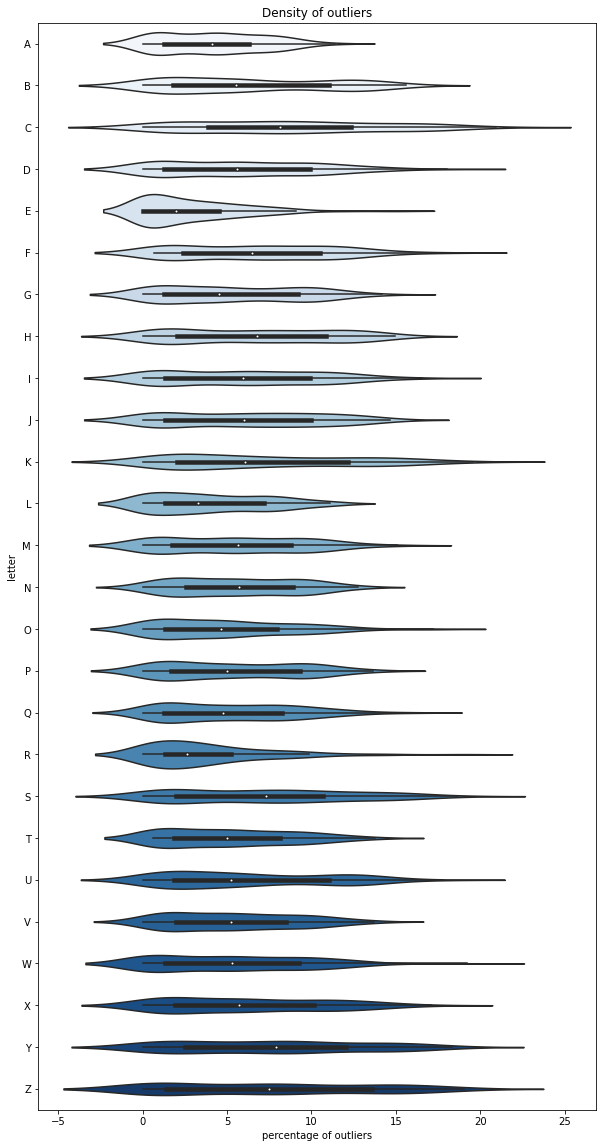

In [76]:
alphabet = list(string.ascii_uppercase)
res_abs = res_abs.fillna(0)
res_rel = res_rel.fillna(0)
alpha_s = ["A", "B", "C"]

plt.figure(figsize=(10,20))
ax = sns.violinplot(data = res_rel[alphabet], orient="h", palette="Blues")
ax.set(xlabel="percentage of outliers", ylabel="letter", title="Density of outliers")
plt.show()
#sns.kdeplot(res_rel["A"], shade = True)



In [42]:
res_abs_plot = pd.DataFrame(columns = ["Letter", "Average"])
res_abs_plot["Letter"] = alphabet

for i in alphabet:
    m = res_abs[i].mean()
    res_abs_plot.loc[(res_abs_plot.Letter == i), 'Average'] = m


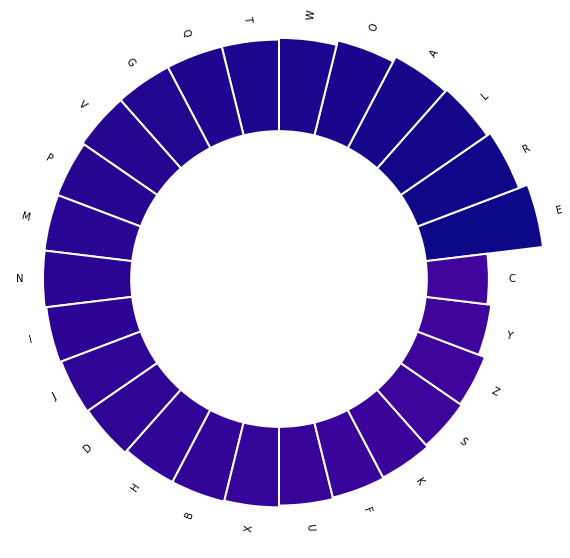

In [63]:
import matplotlib.colors as mcolors

# Reorder the dataframe
res_abs_plot = res_abs_plot.sort_values(by=['Average'])

# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 100
lowerLimit = 30
labelPadding = 4

# Compute max and min in the dataset
max = res_abs_plot['Average'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * res_abs_plot.Average + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(res_abs_plot.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(res_abs_plot.index)+1))
angles = [element * width for element in indexes]
angles


my_cmap = plt.get_cmap("plasma")

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color=my_cmap.colors,
)                           

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, res_abs_plot["Letter"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor")